**Deep Q Learning Project RL**

General Task Description:

-> Given a fixed neural network, you will train an agent which will be able to play cartpole V1 on different pole lengths, e.g. make a generalist.

1. IMPORT WHAT WE NEED

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import gymnasium as gym
from collections import deque
from collections import defaultdict
import matplotlib.pyplot as plt
from test_script import QNetwork
from test_script import bar_plot, test_pole_length, test_script


2. THE BASE DEEP Q LEARNING 

In [2]:
#replay buffer
class ReplayBuffer:
    """
    Replay Buffer to store experience tuples for deep q learning.
    The replay buffer stores experiences from many episodes and randomly samples them during training.
    """
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)


def select_action(state, policy_net, epsilon, action_dim):
    """
    Select action using epsilon-greedy policy - did it with epsilon-greedy because of Assignent 1
    """
    if random.random() < epsilon:
        return random.randrange(action_dim)
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = policy_net(state_tensor)
            return q_values.argmax().item()


def deep_q_learning(epsilon, gamma, alpha, q_network, n_episodes, 
                    pole_lengths=None, env_name='CartPole-v1',
                    batch_size=64, buffer_capacity=50000, 
                    update_target_every=10, epsilon_decay=0.995, 
                    epsilon_min=0.01):
    """
    Deep q learning agent for CartPole-v1 environment with varying pole lengths.
    
    param: epsilon : float - initial exploration rate
    param: gamma : float - discount factor
    param: alpha : float - learning rate
    param: q_network : QNetwork or None - pre-initialized network or None to create new one
    param: n_episodes : int - number of training episodes
    param: pole_lengths : array-like or None - array of pole lengths to train on (default: linspace(0.4, 1.8, 30))
    param: env_name : str - gym environment name
    param: batch_size : int - batch size for training
    param: buffer_capacity : int - replay buffer capacity
    param: update_target_every : int - how often to update target network
    param: epsilon_decay : float - epsilon decay rate per episode
    param: epsilon_min : float - minimum epsilon value

    return: tuple : (policy_net, target_net, episode_returns)
        - trained networks and list of episode rewards
    """

    # initialization of environment
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # initialization of networks if not provided
    if q_network is None:
        policy_net = QNetwork(state_dim, action_dim)
        target_net = QNetwork(state_dim, action_dim)
        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()
    else:
        policy_net = q_network
        target_net = QNetwork(state_dim, action_dim)
        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()

    # initialization of optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=alpha)

    # initialization of replay buffer
    replay_buffer = ReplayBuffer(buffer_capacity)
    
    # pole lengths for training
    if pole_lengths is None:
        pole_lengths = np.linspace(0.4, 1.8, 30)

    # storing episode returns for plotting
    episode_returns = []
    
    # copy of current epsilon value for decay
    epsi = epsilon
    
    # training loop
    for episode in range(n_episodes):
        # randomly select pole length for this episode (we need to figure an experimental setup)
        pole_length = np.random.choice(pole_lengths)
        env.unwrapped.length = pole_length
        
        # reset environment
        state = env.reset()[0]
        episode_reward = 0.0
        
        # epsilon decay
        if epsi > epsilon_min:
            epsi = max(epsilon_min, epsi * epsilon_decay)
        
        # episode loop (1 episode = 1 pole length)
        done = False
        
        while not done:
            # select action
            action = select_action(state, policy_net, epsi, action_dim)
            
            # take step
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # store transition in replay buffer
            replay_buffer.push(state, action, reward, next_state, float(done))

            # deep q learning update (using mini-batch from replay buffer)
            if len(replay_buffer) >= batch_size:
                # sample batch from replay buffer
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                
                # convert to tensors 
                states_t = torch.FloatTensor(states)
                actions_t = torch.LongTensor(actions).unsqueeze(1)
                rewards_t = torch.FloatTensor(rewards).unsqueeze(1)
                next_states_t = torch.FloatTensor(next_states)
                dones_t = torch.FloatTensor(dones).unsqueeze(1)

                #get current q values
                current_q = policy_net(states_t).gather(1, actions_t)
                
                # target values
                with torch.no_grad():
                    next_max = target_net(next_states_t).max(1)[0].unsqueeze(1)
                    td_target = rewards_t + gamma * next_max * (1 - dones_t)
                
                # loss calc
                loss = nn.MSELoss()(current_q, td_target)
                
                # backprop and optimize + gradient clipping
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()
            
            episode_reward += reward
            state = next_state
        
        
        #update target network periodically
        if episode % update_target_every == 0:
            target_net.load_state_dict(policy_net.state_dict())

        #store episode reward
        episode_returns.append(episode_reward)
        
        #only for seeing the progress
        if episode % 100 == 0:
            avg_reward = np.mean(episode_returns[-100:]) if len(episode_returns) >= 100 else np.mean(episode_returns)
            print(f"Episode {episode}/{n_episodes} | "
                  f"Avg Reward: {avg_reward:.1f} | "
                  f"Epsilon: {epsi:.3f}")
    
    env.close()
    
    return (policy_net, target_net, episode_returns)

In [3]:
#Test Replay Buffer
# --- IGNORE ---
rb=ReplayBuffer(3)
rb.push([0,0,0,0], 1, 1.0, [1,1,1,1], False)
print(len(rb), rb.sample(1)[0])

1 ([0, 0, 0, 0], 1, 1.0, [1, 1, 1, 1], False)


In [5]:
#Test the deep q learning function
# --- IGNORE ---
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# --- training test ---
policy_net, target_net, returns = deep_q_learning(
    epsilon=1.0,
    gamma=0.99,
    alpha=1e-3,
    q_network=None,           # create fresh nets
    n_episodes=400, 
    pole_lengths=np.linspace(0.4, 1.2, 5),
    env_name='CartPole-v1',
    batch_size=32,
    buffer_capacity=10000,
    update_target_every=5,
    epsilon_decay=0.98,
    epsilon_min=0.05
)

print("----finished training----")
print("Last 3 episode returns:", returns[-3:] if len(returns) >= 3 else returns)

Episode 0/400 | Avg Reward: 12.0 | Epsilon: 0.980
Episode 100/400 | Avg Reward: 126.2 | Epsilon: 0.130
Episode 200/400 | Avg Reward: 272.3 | Epsilon: 0.050
Episode 300/400 | Avg Reward: 252.0 | Epsilon: 0.050
----finished training----
Last 3 episode returns: [500.0, 214.0, 500.0]


2.1 Approach 1: Using uniform distribution to sample pole lengths

In [4]:
class StratifiedReplayBuffer:
    """
    Replay Buffer to store experience tuples for deep q learning.
    The replay buffer stores experiences from many episodes and randomly samples them during training.
    """
    def __init__(self, capacity):
        self.buffer = {}
        self.capacity = capacity
    
    def push(self, label, state, action, reward, next_state, done):
        sample = (state, action, reward, next_state, done)
        if label not in  self.buffer:
            self.buffer[label] = deque()
            num_labels = len(self.buffer)
            new_max_buffer_capacity = self.capacity // num_labels
            remainder = self.capacity % num_labels
            # dynamically adapt deque max cap as we add sampled pole lengths to our superbuffer. 
            for i, existing_label in enumerate(self.buffer.keys()):
                current_maxlen = new_max_buffer_capacity + (1 if i < remainder else 0)        
                old_deque = self.buffer[existing_label]
                self.buffer[existing_label] = deque(old_deque, maxlen=current_maxlen) 


        self.buffer[label].append(sample)

    def sample(self, batch_size):
        if not self.buffer:
            return []
        labels = list(self.buffer.keys()) 
        samples_per_label = batch_size//len(labels)
        remainder = batch_size % len(labels)
        all_samples = []
        # iterate through all labels (pole lengths) to ensure most even distribution in sample (uniform)
        for i, label in enumerate(labels):
            label_buffer = self.buffer[label]
            num_to_sample = samples_per_label + (1 if i < remainder else 0)
            num_to_sample = min(num_to_sample, len(label_buffer))
            batch = random.sample(label_buffer, num_to_sample)
            all_samples.extend(batch)
        
        random.shuffle(all_samples)
        return all_samples
    
    def __len__(self):
        return sum(len(d) for d in self.buffer.values())

In [11]:
def select_action(state, policy_net, epsilon, action_dim):
    """
    Select action using epsilon-greedy policy - did it with epsilon-greedy because of Assignent 1
    """
    if random.random() < epsilon:
        return random.randrange(action_dim)
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = policy_net(state_tensor)
            return q_values.argmax().item()


def deep_q_learning_strati_buff(epsilon, gamma, alpha, q_network, n_episodes, 
                    pole_lengths=None, env_name='CartPole-v1',
                    batch_size=64, buffer_capacity=50000, 
                    update_target_every=10, epsilon_decay=0.995, 
                    epsilon_min=0.01):
    """
    Deep q learning agent for CartPole-v1 environment with varying pole lengths.
    
    param: epsilon : float - initial exploration rate
    param: gamma : float - discount factor
    param: alpha : float - learning rate
    param: q_network : QNetwork or None - pre-initialized network or None to create new one
    param: n_episodes : int - number of training episodes
    param: pole_lengths : array-like or None - array of pole lengths to train on (default: linspace(0.4, 1.8, 30))
    param: env_name : str - gym environment name
    param: batch_size : int - batch size for training
    param: buffer_capacity : int - replay buffer capacity
    param: update_target_every : int - how often to update target network
    param: epsilon_decay : float - epsilon decay rate per episode
    param: epsilon_min : float - minimum epsilon value

    return: tuple : (policy_net, target_net, episode_returns)
        - trained networks and list of episode rewards
    """

    # initialization of environment
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # initialization of networks if not provided
    if q_network is None:
        policy_net = QNetwork(state_dim, action_dim)
        target_net = QNetwork(state_dim, action_dim)
        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()
    else:
        policy_net = q_network
        target_net = QNetwork(state_dim, action_dim)
        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()

    # initialization of optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=alpha)

    # initialization of replay buffer
    replay_buffer = StratifiedReplayBuffer(buffer_capacity)
    
    # pole lengths for training
    if pole_lengths is None:
        pole_lengths = np.linspace(0.4, 1.8, 30)

    # storing episode returns for plotting
    episode_returns = []
    
    # copy of current epsilon value for decay
    epsi = epsilon
    
    # training loop
    for episode in range(n_episodes):
        # randomly select pole length for this episode (we need to figure an experimental setup)
        pole_length = np.random.choice(pole_lengths)
        env.unwrapped.length = pole_length
        
        # reset environment
        state = env.reset()[0]
        episode_reward = 0.0
        
        # epsilon decay
        if epsi > epsilon_min:
            epsi = max(epsilon_min, epsi * epsilon_decay)
        
        # episode loop (1 episode = 1 pole length)
        done = False
        
        while not done:
            # select action
            action = select_action(state, policy_net, epsi, action_dim)
            
            # take step
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # store transition in replay buffer
            replay_buffer.push(pole_length, state, action, reward, next_state, float(done))

            # deep q learning update (using mini-batch from replay buffer)
            if len(replay_buffer) >= batch_size:
                # sample batch from replay buffer
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                
                # convert to tensors 
                states_t = torch.FloatTensor(states)
                actions_t = torch.LongTensor(actions).unsqueeze(1)
                rewards_t = torch.FloatTensor(rewards).unsqueeze(1)
                next_states_t = torch.FloatTensor(next_states)
                dones_t = torch.FloatTensor(dones).unsqueeze(1)

                #get current q values
                current_q = policy_net(states_t).gather(1, actions_t)
                
                # target values
                with torch.no_grad():
                    next_max = target_net(next_states_t).max(1)[0].unsqueeze(1)
                    td_target = rewards_t + gamma * next_max * (1 - dones_t)
                
                # loss calc
                loss = nn.MSELoss()(current_q, td_target)
                
                # backprop and optimize + gradient clipping
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()
            
            episode_reward += reward
            state = next_state
        
        
        #update target network periodically
        if episode % update_target_every == 0:
            target_net.load_state_dict(policy_net.state_dict())

        #store episode reward
        episode_returns.append(episode_reward)
        
        #only for seeing the progress
        if episode % 50 == 0:
            avg_reward = np.mean(episode_returns[-50:]) if len(episode_returns) >= 50 else np.mean(episode_returns)
            print(f"Episode {episode}/{n_episodes} | "
                  f"Avg Reward: {avg_reward:.1f} | "
                  f"Epsilon: {epsi:.3f}")
    
    env.close()
    
    return policy_net, target_net, episode_returns

2.2 Approach 2: Scrappy Adversial - hitting the weak spots

2.2.1 Adaptive curriculum learning


In [6]:
class AdaptiveCurriculumLearning:
    """ 
    Adaptive curriculum learning offers an object to store the accumulated rewards, 
    performances, difficulty socores, and probabilities for each pole length. 
    We check the last n (LOOK_BACK_WINDOW) rewards a pole has obtained and assign probabilities 
    to sample each length for an episode. The goal is to attack the policy on its weak spots, 
    we prioritize training on weak performing lengths. This should shift performance metrics and keeps 
    our attacks adaptive as we target weakest. 
    param: all_pole_lengths : numpy.ndarray - stores all the pole lengths
    """
    LOOK_BACK_WINDOW = 20 # we only consider the last 20 rewards a pole has gotten (captures more sensitive information)
    P_ADAPTIVE = 0.8 # probability of using adaptive probability distribution or uniform random
    def __init__(self, all_pole_lengths):
        self.all_pole_lengths = all_pole_lengths
        self.rewards = defaultdict(list) # storing pole length episode reward for approach 2 (see 2.2)
        self.performances = {} # keep track of performance metric for each pole length 
        self.difficulty_scores = {} # difficulty_scores
        self.distribution = {} # probability distribution for pole lengths to sample from
        
        # initialize difficulties and probabilities (initially prob is uniform)
        initial_prob = 1.0 / len(all_pole_lengths)
        self.i_p = initial_prob
        for length in all_pole_lengths:
            self.difficulty_scores[length] = 1.0
            self.distribution[length] = initial_prob

    def update_rewards(self, pole_length, reward):
        self.rewards[pole_length].append(reward)

    def update_performances(self, pole_length):
        """
        Here we update the performance of a pole, 
        """
        reward_list = self.rewards[pole_length]

        # if a pole has not been played yet, it will be assigned a performance metric of 0
        if not reward_list:
            metric = 0
        else:
            # here we use a LOOK BACK WINDOW so that we dont use over-stabilized episode rewards
            metric = np.mean(reward_list[-self.LOOK_BACK_WINDOW:])
        self.performances[pole_length] = metric

    def update_difficulties(self):
        """
        Difficulties are inversely proportional to the performance metrics.
        The worse a pole length has performed, the higher the diff score (diff=1 being the worst performing, diff=0 being best).
        These require global updates as the update is relative to the totality of pole lengths.
        Also normalizing + scaling the values down. Metrics can offer quite larger values otherwise. 
        """
        M_max = self.find_max()
        M_min = self.find_min()
        diff_M = M_max - M_min

        # update all difficulty scores with new information
        for pole_length, metric in self.performances.items():
            if diff_M == 0:
                difficulty = 1
            else:
                difficulty = 1 - ((metric-M_min) / diff_M) # if best perform, diff is 0 >>> probability assignment will be 0
            self.difficulty_scores[pole_length] = difficulty
    
    def update_distribution(self):
        """ 
        Distribution is also global, here we require an update proportional to the totality. 
        Normalizing the probabilities (between 0 and 1)
        """
        if not self.difficulty_scores:
            return
        total_difficulty = sum(self.difficulty_scores.values())

        if total_difficulty > 0:
            for pole_length, difficulty in self.difficulty_scores.items():
                self.distribution[pole_length] = difficulty / total_difficulty
        else:
            for pole_length in self.all_pole_lengths:
                self.distribution[pole_length] = self.i_p
    
    def sample_length(self):
        """
        Here select the pole length using either uniform or categorical prob distribution. 
        """
        if random.random() < self.P_ADAPTIVE:
            pole_lengths = list(self.distribution.keys())
            probs = list(self.distribution.values())

            # if our prob dist is empty, we fallback to uniform selection
            if not pole_lengths or sum(probs) == 0:
                return np.random.choice(self.all_pole_lengths)
            
            # selection based on categorical sampling (discrete prob distribution)
            return np.random.choice(a=pole_lengths, p=probs, size=1)[0]
        else:
            return np.random.choice(self.all_pole_lengths)

    def find_max(self):
        """
        Find max performing pole length
        """
        if not self.performances:
            return 0
        return max(self.performances.values())

    def find_min(self):
        """
        Find min performing pole length
        """
        if not self.performances:
            return 0
        return min(self.performances.values())
    
    def calculate_pole_stats(self):
        """
        Nice display function for avg reward of each pole. Not functionally important at all. 
        """
        avg_pole_stats = {}
        
        for pole_length, rewards_list in self.rewards.items():
            # Only process if the list is not empty
            if rewards_list:
                avg_reward = np.mean(rewards_list)
                count = len(rewards_list)
            else:
                avg_reward = 0.0
                count = 0
            avg_pole_stats[pole_length] = {
                "average_reward": avg_reward,
                "episode_count": count
            }
        for p, avg in avg_pole_stats.items():
            print(f"Pole length {p} has avg reward {avg}")
        return avg_pole_stats


In [7]:
class ReplayBuffer:
    """
    Replay Buffer to store experience tuples for deep q learning.
    The replay buffer stores experiences from many episodes and randomly samples them during training.
    """
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)


def select_action(state, policy_net, epsilon, action_dim):
    """
    Select action using epsilon-greedy policy - did it with epsilon-greedy because of Assignent 1
    """
    if random.random() < epsilon:
        return random.randrange(action_dim)
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = policy_net(state_tensor)
            return q_values.argmax().item()


def deep_q_learning_acl(epsilon, gamma, alpha, q_network, n_episodes,
                    uniform_episode_training_cap=300,
                    pole_lengths=None, env_name='CartPole-v1',
                    batch_size=64, buffer_capacity=50000, 
                    update_target_every=10, epsilon_decay=0.995, 
                    epsilon_min=0.01):
    """
    Deep q learning agent for CartPole-v1 environment with varying pole lengths.
    
    param: epsilon : float - initial exploration rate
    param: gamma : float - discount factor
    param: alpha : float - learning rate
    param: q_network : QNetwork or None - pre-initialized network or None to create new one
    param: n_episodes : int - number of training episodes
    param: uniform_episode_training_cap : int - number episodes trained with uniform length selection
    param: p_adaptive : float - probability to select pole length from sample distribution, after uniform_episode_training_cap
    param: lb_window : int - look back window used to compute performance metric, number of recent pole length performances
    param: pole_lengths : array-like or None - array of pole lengths to train on (default: linspace(0.4, 1.8, 30))
    param: env_name : str - gym environment name
    param: batch_size : int - batch size for training
    param: buffer_capacity : int - replay buffer capacity
    param: update_target_every : int - how often to update target network
    param: epsilon_decay : float - epsilon decay rate per episode
    param: epsilon_min : float - minimum epsilon value

    return: tuple : (policy_net, target_net, episode_returns)
        - trained networks and list of episode rewards
    """

    # initialization of environment
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # initialization of networks if not provided
    if q_network is None:
        policy_net = QNetwork(state_dim, action_dim)
        target_net = QNetwork(state_dim, action_dim)
        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()
    else:
        policy_net = q_network
        target_net = QNetwork(state_dim, action_dim)
        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()

    # initialization of optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=alpha)

    # initialization of replay buffer
    replay_buffer = ReplayBuffer(buffer_capacity)
    
    # pole lengths for training
    if pole_lengths is None:
        pole_lengths = np.linspace(0.4, 1.8, 30)

    # storing episode returns for plotting
    episode_returns = []

    # initialize the acl class for adaptive hyperparametre sampling
    acl = AdaptiveCurriculumLearning(pole_lengths)

    # copy of current epsilon value for decay
    epsi = epsilon
    
    # training loop
    for episode in range(n_episodes):
        # if current episode is below the uniform_episode_training_cap we select from a uniform distr
        if episode < uniform_episode_training_cap:
            pole_length = np.random.choice(pole_lengths)
        # else use adaptive probability distrubition 
        else: 
            pole_length = acl.sample_length()

        env.unwrapped.length = pole_length
        
        # reset environment
        state = env.reset()[0]
        episode_reward = 0.0
        
        # epsilon decay
        if epsi > epsilon_min:
            epsi = max(epsilon_min, epsi * epsilon_decay)
        
        # episode loop (1 episode = 1 pole length)
        done = False
        
        while not done:
            # select action
            action = select_action(state, policy_net, epsi, action_dim)
            
            # take step
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # store transition in replay buffer
            replay_buffer.push(state, action, reward, next_state, float(done))

            # deep q learning update (using mini-batch from replay buffer)
            if len(replay_buffer) >= batch_size:
                # sample batch from replay buffer
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                
                # convert to tensors 
                states_t = torch.FloatTensor(states)
                actions_t = torch.LongTensor(actions).unsqueeze(1)
                rewards_t = torch.FloatTensor(rewards).unsqueeze(1)
                next_states_t = torch.FloatTensor(next_states)
                dones_t = torch.FloatTensor(dones).unsqueeze(1)

                #get current q values
                current_q = policy_net(states_t).gather(1, actions_t)
                
                # target values
                with torch.no_grad():
                    next_max = target_net(next_states_t).max(1)[0].unsqueeze(1)
                    td_target = rewards_t + gamma * next_max * (1 - dones_t)
                
                # loss calc
                loss = nn.MSELoss()(current_q, td_target)
                
                # backprop and optimize + gradient clipping
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()
            
            episode_reward += reward
            state = next_state
        
        
        #update target network periodically
        if episode % update_target_every == 0:
            target_net.load_state_dict(policy_net.state_dict())

        #store episode reward
        episode_returns.append(episode_reward)

        # update acl for rewards, performance metrics, scores, and probs
        # difficulty scores and probabilities are global updates, can be seen in the respective update methods
        acl.update_rewards(pole_length, episode_reward)
        if episode >= uniform_episode_training_cap:
            acl.update_performances(pole_length)
            acl.update_difficulties()
            acl.update_distribution()

        #only for seeing the progress
        if episode % 50 == 0:
            avg_reward = np.mean(episode_returns[-100:]) if len(episode_returns) >= 100 else np.mean(episode_returns)
            print(f"Episode {episode}/{n_episodes} | "
                  f"Avg Reward: {avg_reward:.1f} | "
                  f"Epsilon: {epsi:.3f} | "
                  f"Probability Distribution{acl.distribution} | \n" 
                  f"Pole Length Performances{acl.performances} | \n"
                  )
            
    
    env.close()
    
    return policy_net, target_net, episode_returns, acl

In [ ]:
#Test the deep q learning function
# --- IGNORE ---
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# --- training test ---
policy_net, target_net, returns, acl = deep_q_learning(
    epsilon=1.0,
    gamma=0.99,
    alpha=1e-3,
    q_network=None,           # create fresh nets
    n_episodes=200, 
    uniform_episode_training_cap=100, # here you set the moment from which adaptive CL is applied 
    pole_lengths=np.linspace(0.4, 1.2, 5),
    env_name='CartPole-v1',
    batch_size=32,
    buffer_capacity=10000,
    update_target_every=5,
    epsilon_decay=0.98,
    epsilon_min=0.05
)

print("----finished training----")
print("Last 3 episode returns:", returns[-3:] if len(returns) >= 3 else returns)

Episode 0/200 | Avg Reward: 12.0 | Epsilon: 0.980 | {np.float64(0.4): 0.2, np.float64(0.6): 0.2, np.float64(0.8): 0.2, np.float64(1.0): 0.2, np.float64(1.2): 0.2} | 
{} | 

Episode 50/200 | Avg Reward: 59.7 | Epsilon: 0.357 | {np.float64(0.4): 0.2, np.float64(0.6): 0.2, np.float64(0.8): 0.2, np.float64(1.0): 0.2, np.float64(1.2): 0.2} | 
{} | 

Episode 100/200 | Avg Reward: 107.6 | Epsilon: 0.130 | {np.float64(0.4): 0.2, np.float64(0.6): 0.2, np.float64(0.8): 0.2, np.float64(1.0): 0.2, np.float64(1.2): 0.2} | 
{np.float64(1.0): np.float64(76.96296296296296)} | 

Episode 150/200 | Avg Reward: 152.8 | Epsilon: 0.050 | {np.float64(0.4): np.float64(0.0757035944309186), np.float64(0.6): np.float64(0.0), np.float64(0.8): np.float64(0.3440014099438963), np.float64(1.0): np.float64(0.4083047284174575), np.float64(1.2): np.float64(0.17199026720772756)} | 
{np.float64(1.0): np.float64(105.02272727272727), np.float64(1.2): np.float64(127.34482758620689), np.float64(0.8): np.float64(111.0967741935

In [48]:
# acl.calculate_pole_stats()
print(type(acl.all_pole_lengths))
print(acl.performances)
print(acl.difficulty_scores)
print(acl.distribution)

<class 'numpy.ndarray'>
{np.float64(1.0): np.float64(106.85483870967742), np.float64(1.2): np.float64(127.03030303030303), np.float64(0.8): np.float64(113.90196078431373), np.float64(0.6): np.float64(141.52173913043478), np.float64(0.4): np.float64(133.3548387096774)}
{np.float64(0.4): np.float64(0.2355820774754731), np.float64(0.6): np.float64(0.0), np.float64(0.8): np.float64(0.7967190031671615), np.float64(1.0): np.float64(1.0), np.float64(1.2): np.float64(0.4180193765305529)}
{np.float64(0.4): np.float64(0.09614337454752851), np.float64(0.6): np.float64(0.0), np.float64(0.8): np.float64(0.32514890076308484), np.float64(1.0): np.float64(0.4081098850040415), np.float64(1.2): np.float64(0.17059783968534506)}


2.3 Approach 3: Training on the least visited pole lengths

Description of difference in implementation (used claude to get the table)

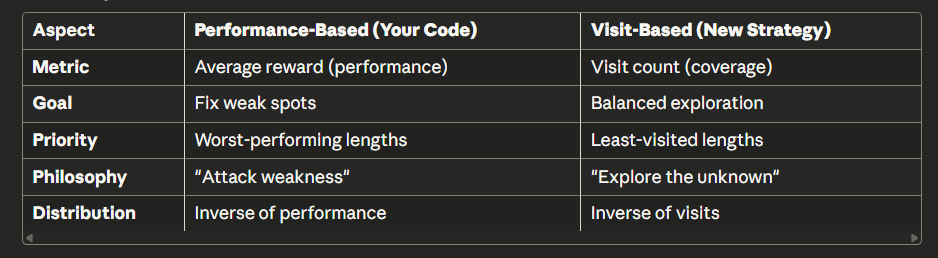

In [8]:
class ExplorationDiversityCurriculum:
    """ 
    Exploration Diversity Curriculum prioritizes pole lengths that have been visited LEAST.
    This ensures balanced coverage of the pole length space and prevents over-training
    on familiar lengths while neglecting others.
    
    basically saying "Explore what you haven't seen"
    
    param: all_pole_lengths : numpy.ndarray - stores all the pole lengths
    """
    
    P_ADAPTIVE = 0.8  #probability of using adaptive (exploration-based) vs uniform
    MIN_VISITS_THRESHOLD = 10  #minimum visits before a length is considered "explored"
    
    def __init__(self, all_pole_lengths):
        self.all_pole_lengths = all_pole_lengths
        self.visit_counts = defaultdict(int)  # track how many times each length was visited
        self.rewards = defaultdict(list) 
        self.rarity_scores = {}  # how "rare" each pole length is (inverse of visits)
        self.distribution = {}  # probability distribution for sampling
        
        #initialize with uniform distribution
        initial_prob = 1.0 / len(all_pole_lengths)
        self.initial_prob = initial_prob
        for length in all_pole_lengths:
            self.rarity_scores[length] = 1.0
            self.distribution[length] = initial_prob
    
    def update_visit(self, pole_length):
        """
        Increment visit counter for pole length
        """
        self.visit_counts[pole_length] += 1
    
    def update_rewards(self, pole_length, reward):
        """
        Track rewards (for analysis purposes)
        """
        self.rewards[pole_length].append(reward)
    
    def update_rarity_scores(self):
        """
        Rarity scores are INVERSELY proportional to visit counts.
        Least visited = highest rarity = highest sampling probability
        
        This creates an exploration bonus for under-explored pole lengths.
        """
        if not self.visit_counts:
            return
        
        max_visits = max(self.visit_counts.values())
        min_visits = min(self.visit_counts.values())
        diff_visits = max_visits - min_visits
        
        for pole_length in self.all_pole_lengths:
            visits = self.visit_counts.get(pole_length, 0)
            
            if diff_visits == 0:
                #all lengths visited equally - uniform rarity
                rarity = 1.0
            else:
                #inverse normalization: least visited = highest rarity (closer to 1)
                #most visited = lowest rarity (closer to 0)
                rarity = 1.0 - ((visits - min_visits) / diff_visits)
            
            #add bonus for completely unvisited lengths
            if visits == 0:
                rarity = 2.0  #double rarity - ultra rare
            
            self.rarity_scores[pole_length] = rarity
    
    def update_distribution(self):
        """
        Update sampling distribution based on rarity scores.
        Normalize probabilities to sum to 1.
        """
        if not self.rarity_scores:
            return
        
        total_rarity = sum(self.rarity_scores.values())
        
        if total_rarity > 0:
            for pole_length, rarity in self.rarity_scores.items():
                self.distribution[pole_length] = rarity / total_rarity
        else:
            #fallback to uniform
            for pole_length in self.all_pole_lengths:
                self.distribution[pole_length] = self.initial_prob
    
    def sample_length(self):
        """
        Sample pole length using either:
        - Adaptive (exploration-based) distribution (P_ADAPTIVE probability)
        - Uniform random (1 - P_ADAPTIVE probability)
        """
        if random.random() < self.P_ADAPTIVE:
            pole_lengths = list(self.distribution.keys())
            probs = list(self.distribution.values())
            
            #fallback to uniform if distribution is invalid
            if not pole_lengths or sum(probs) == 0:
                return np.random.choice(self.all_pole_lengths)
            
            #sample based on rarity (exploration priority)
            return np.random.choice(a=pole_lengths, p=probs, size=1)[0]
        else:
            return np.random.choice(self.all_pole_lengths)
    
    def get_exploration_stats(self):
        """
        Return statistics about exploration coverage
        """
        total_visits = sum(self.visit_counts.values())
        unvisited = [l for l in self.all_pole_lengths if self.visit_counts[l] == 0]
        under_explored = [l for l in self.all_pole_lengths 
                         if 0 < self.visit_counts[l] < self.MIN_VISITS_THRESHOLD]
        
        return {
            'total_visits': total_visits,
            'unvisited_count': len(unvisited),
            'under_explored_count': len(under_explored),
            'visit_counts': dict(self.visit_counts),
            'min_visits': min(self.visit_counts.values()) if self.visit_counts else 0,
            'max_visits': max(self.visit_counts.values()) if self.visit_counts else 0,
        }
    
    def calculate_pole_stats(self):
        """
        Display statistics for each pole length
        """
        stats = {}
        
        for pole_length in self.all_pole_lengths:
            visits = self.visit_counts.get(pole_length, 0)
            rewards_list = self.rewards.get(pole_length, [])
            
            if rewards_list:
                avg_reward = np.mean(rewards_list)
            else:
                avg_reward = 0.0
            
            stats[pole_length] = {
                "visits": visits,
                "average_reward": avg_reward,
                "rarity_score": self.rarity_scores.get(pole_length, 1.0),
                "sampling_prob": self.distribution.get(pole_length, self.initial_prob)
            }
        
        return stats


def select_action(state, policy_net, epsilon, action_dim):
    """
    Select action using epsilon-greedy policy
    """
    if random.random() < epsilon:
        return random.randrange(action_dim)
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = policy_net(state_tensor)
            return q_values.argmax().item()


def deep_q_learning_exploration_diversity(
        epsilon, gamma, alpha, q_network, n_episodes,
        uniform_episode_training_cap=300,
        pole_lengths=None, env_name='CartPole-v1',
        batch_size=64, buffer_capacity=50000, 
        update_target_every=10, epsilon_decay=0.995, 
        epsilon_min=0.01):
    """
    Deep q learning with Exploration Diversity Curriculum
    
    This strategy prioritizes training on LEAST-VISITED pole lengths
    
    param: epsilon : float - initial exploration rate
    param: gamma : float - discount factor
    param: alpha : float - learning rate
    param: q_network : QNetwork or None - pre-initialized network or None to create new one
    param: n_episodes : int - number of training episodes
    param: uniform_episode_training_cap : int - number episodes trained with uniform length selection
    param: p_adaptive : float - probability to select pole length from sample distribution, after uniform_episode_training_cap
    param: lb_window : int - look back window used to compute performance metric, number of recent pole length performances
    param: pole_lengths : array-like or None - array of pole lengths to train on (default: linspace(0.4, 1.8, 30))
    param: env_name : str - gym environment name
    param: batch_size : int - batch size for training
    param: buffer_capacity : int - replay buffer capacity
    param: update_target_every : int - how often to update target network
    param: epsilon_decay : float - epsilon decay rate per episode
    param: epsilon_min : float - minimum epsilon value
    
    return: tuple : (policy_net, target_net, episode_returns, exploration_diversity_curriculum)
        - trained networks and list of episode rewards
    """
    
    #initialize environment
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    #initialize networks
    if q_network is None:
        policy_net = QNetwork(state_dim, action_dim)
        target_net = QNetwork(state_dim, action_dim)
        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()
    else:
        policy_net = q_network
        target_net = QNetwork(state_dim, action_dim)
        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()
    
    #initialize optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=alpha)
    
    #initialize replay buffer
    replay_buffer = ReplayBuffer(buffer_capacity)
    
    #pole lengths for training
    if pole_lengths is None:
        pole_lengths = np.linspace(0.4, 1.8, 30)
    
    #storing episode returns
    episode_returns = []
    
    #initialize Exploration Diversity Curriculum
    exploration_diversity_curriculum = ExplorationDiversityCurriculum(pole_lengths)
    
    #epsilon copy
    epsi = epsilon
    
    #training loop
    for episode in range(n_episodes):
        #phase 1: uniform sampling for initial exploration
        if episode < uniform_episode_training_cap:
            pole_length = np.random.choice(pole_lengths)
        #phase 2: prioritize least-visited lengths
        else:
            pole_length = exploration_diversity_curriculum.sample_length()
        
        env.unwrapped.length = pole_length
        
        #track that we visited this length
        exploration_diversity_curriculum.update_visit(pole_length)
        
        #reset environment
        state = env.reset()[0]
        episode_reward = 0.0
        
        #epsilon decay
        if epsi > epsilon_min:
            epsi = max(epsilon_min, epsi * epsilon_decay)
        
        #episode loop
        done = False
        
        while not done:
            #select action
            action = select_action(state, policy_net, epsi, action_dim)
            
            #take step
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            #store transition
            replay_buffer.push(state, action, reward, next_state, float(done))
            
            #training step
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)
                
                states_t = torch.FloatTensor(states)
                actions_t = torch.LongTensor(actions).unsqueeze(1)
                rewards_t = torch.FloatTensor(rewards).unsqueeze(1)
                next_states_t = torch.FloatTensor(next_states)
                dones_t = torch.FloatTensor(dones).unsqueeze(1)
                
                current_q = policy_net(states_t).gather(1, actions_t)
                
                with torch.no_grad():
                    next_max = target_net(next_states_t).max(1)[0].unsqueeze(1)
                    td_target = rewards_t + gamma * next_max * (1 - dones_t)
                
                loss = nn.MSELoss()(current_q, td_target)
                
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                optimizer.step()
            
            episode_reward += reward
            state = next_state
        
        #update target network periodically
        if episode % update_target_every == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        #store episode return
        episode_returns.append(episode_reward)
        
        #update curriculum: track rewards and update rarity-based distribution
        exploration_diversity_curriculum.update_rewards(pole_length, episode_reward)
        
        if episode >= uniform_episode_training_cap:
            exploration_diversity_curriculum.update_rarity_scores()
            exploration_diversity_curriculum.update_distribution()

        #progress logging
        if episode % 50 == 0:
            avg_reward = np.mean(episode_returns[-100:]) if len(episode_returns) >= 100 else np.mean(episode_returns)
            exploration_stats = exploration_diversity_curriculum.get_exploration_stats()

            print(f"Episode {episode}/{n_episodes} | "
                  f"Avg Reward: {avg_reward:.1f} | "
                  f"Epsilon: {epsi:.3f}")
            print(f"  Exploration Stats: Unvisited={exploration_stats['unvisited_count']}, "
                  f"Min visits={exploration_stats['min_visits']}, "
                  f"Max visits={exploration_stats['max_visits']}")
            
            #show top 3 most likely to be sampled (least visited)
            top_3_rare = sorted(exploration_diversity_curriculum.distribution.items(), key=lambda x: x[1], reverse=True)[:3]
            print(f"  Prioritizing (least visited): {[f'{l:.2f}({p:.3f})' for l, p in top_3_rare]}")
    
    env.close()

    #am returning also the policy in case we want to save it to test later 
    return policy_net, target_net, episode_returns, exploration_diversity_curriculum

Test the thing:

In [7]:
#Test the deep q learning function
# --- IGNORE ---
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# --- training test ---
policy_net, target_net, returns, exploration_diversity_curriculum = deep_q_learning_exploration_diversity(
    epsilon=1.0,
    gamma=0.99,
    alpha=1e-3,
    q_network=None,           # create fresh nets
    n_episodes=500, 
    uniform_episode_training_cap=100, # here you set the moment from which exploration diversity is applied
    pole_lengths=np.linspace(0.4, 1.2, 5),
    env_name='CartPole-v1',
    batch_size=32,
    buffer_capacity=10000,
    update_target_every=5,
    epsilon_decay=0.98,
    epsilon_min=0.05
)

print("----finished training----")
print("Last 3 episode returns:", returns[-3:] if len(returns) >= 3 else returns)

# Display final statistics
print("\n" + "="*70)
print("FINAL EXPLORATION STATISTICS")
print("="*70)

final_stats = exploration_diversity_curriculum.calculate_pole_stats()

print("\nPole Length Statistics (sorted by visits):")
sorted_stats = sorted(final_stats.items(), key=lambda x: x[1]['visits'])

print(f"\n{'Pole Length':<12} {'Visits':<8} {'Avg Reward':<12} {'Rarity':<10} {'Prob':<10}")
print("-"*70)
for pole_length, stats in sorted_stats:
    print(f"{pole_length:<12.2f} {stats['visits']:<8} "
            f"{stats['average_reward']:<12.1f} "
              f"{stats['rarity_score']:<10.3f} "
              f"{stats['sampling_prob']:<10.4f}")

Episode 0/500 | Avg Reward: 16.0 | Epsilon: 0.980
  Exploration Stats: Unvisited=4, Min visits=0, Max visits=1
  Prioritizing (least visited): ['0.40(0.200)', '0.60(0.200)', '0.80(0.200)']


C:\Users\Teodora\AppData\Local\Temp\ipykernel_8564\3387781163.py:274: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  states_t = torch.FloatTensor(states)


Episode 50/500 | Avg Reward: 42.5 | Epsilon: 0.357
  Exploration Stats: Unvisited=0, Min visits=7, Max visits=14
  Prioritizing (least visited): ['0.40(0.200)', '0.60(0.200)', '0.80(0.200)']
Episode 100/500 | Avg Reward: 88.6 | Epsilon: 0.130
  Exploration Stats: Unvisited=0, Min visits=16, Max visits=27
  Prioritizing (least visited): ['0.80(0.324)', '0.40(0.265)', '1.20(0.235)']
Episode 150/500 | Avg Reward: 137.5 | Epsilon: 0.050
  Exploration Stats: Unvisited=0, Min visits=30, Max visits=31
  Prioritizing (least visited): ['0.40(0.250)', '0.60(0.250)', '1.00(0.250)']
Episode 200/500 | Avg Reward: 148.0 | Epsilon: 0.050
  Exploration Stats: Unvisited=0, Min visits=40, Max visits=41
  Prioritizing (least visited): ['0.40(0.250)', '0.60(0.250)', '0.80(0.250)']
Episode 250/500 | Avg Reward: 143.2 | Epsilon: 0.050
  Exploration Stats: Unvisited=0, Min visits=50, Max visits=51
  Prioritizing (least visited): ['0.40(0.250)', '0.60(0.250)', '1.00(0.250)']
Episode 300/500 | Avg Reward: 142.

3. MAIN TRAINING FUNCTION

In [12]:
# print("---TRAINING BASELINE - 5000 EPISODES---")
# policy_net, target_net, returns = deep_q_learning(
#     epsilon=1.0,
#     gamma=0.99,
#     alpha=1e-3,
#     q_network=None,           # create fresh nets
#     n_episodes=5000, 
#     pole_lengths=np.linspace(0.4, 1.8, 30),
#     env_name='CartPole-v1',
#     batch_size=32,
#     buffer_capacity=10000,
#     update_target_every=5,
#     epsilon_decay=0.999,
#     epsilon_min=0.05
# )

# torch.save(policy_net.state_dict(), "baseline_policy.pth")
# print("Saved policy_net to baseline_policy.pth")

print("---TRAINING STRATIFIED BUFFER - 5000 EPISODES---")
policy_net, target_net, returns = deep_q_learning_strati_buff(
    epsilon=1.0,
    gamma=0.99,
    alpha=1e-3,
    q_network=None,           # create fresh nets
    n_episodes=5000, 
    pole_lengths=np.linspace(0.4, 1.8, 30),
    env_name='CartPole-v1',
    batch_size=32,
    buffer_capacity=10000,
    update_target_every=5,
    epsilon_decay=0.999,
    epsilon_min=0.05
)

torch.save(policy_net.state_dict(), "strati_buff_policy.pth")
print("Saved policy_net to strati_buff_policy.pth")

print("---TRAINING ACL - 5000 EPISODES---")
policy_net, target_net, returns, acl = deep_q_learning_acl(
    epsilon=1.0,
    gamma=0.99,
    alpha=1e-3,
    q_network=None,           # create fresh nets
    n_episodes=5000, 
    uniform_episode_training_cap=1000, # here you set the moment from which adaptive CL is applied 
    pole_lengths=np.linspace(0.4, 1.8, 30),
    env_name='CartPole-v1',
    batch_size=32,
    buffer_capacity=10000,
    update_target_every=5,
    epsilon_decay=0.999,
    epsilon_min=0.05
)

torch.save(policy_net.state_dict(), "acl_policy.pth")
print("Saved policy_net to acl_policy.pth")

print("---TRAINING EXPLORATION DIVERSITY - 5000 EPISODES---")
policy_net, target_net, returns, exploration_diversity_curriculum = deep_q_learning_exploration_diversity(
    epsilon=1.0,
    gamma=0.99,
    alpha=1e-3,
    q_network=None,           # create fresh nets
    n_episodes=5000, 
    uniform_episode_training_cap=1000, # here you set the moment from which exploration diversity is applied
    pole_lengths=np.linspace(0.4, 1.8, 30),
    env_name='CartPole-v1',
    batch_size=32,
    buffer_capacity=10000,
    update_target_every=5,
    epsilon_decay=0.999,
    epsilon_min=0.05
)

torch.save(policy_net.state_dict(), "exploration_diversity_policy.pth")
print("Saved policy_net to exploration_diversity_policy.pth")

---TRAINING STRATIFIED BUFFER - 5000 EPISODES---
Episode 0/5000 | Avg Reward: 72.0 | Epsilon: 0.999
Episode 50/5000 | Avg Reward: 33.1 | Epsilon: 0.950
Episode 100/5000 | Avg Reward: 38.2 | Epsilon: 0.904
Episode 150/5000 | Avg Reward: 50.9 | Epsilon: 0.860
Episode 200/5000 | Avg Reward: 55.4 | Epsilon: 0.818
Episode 250/5000 | Avg Reward: 53.5 | Epsilon: 0.778
Episode 300/5000 | Avg Reward: 50.9 | Epsilon: 0.740
Episode 350/5000 | Avg Reward: 59.9 | Epsilon: 0.704
Episode 400/5000 | Avg Reward: 61.7 | Epsilon: 0.670
Episode 450/5000 | Avg Reward: 59.6 | Epsilon: 0.637
Episode 500/5000 | Avg Reward: 93.2 | Epsilon: 0.606
Episode 550/5000 | Avg Reward: 59.7 | Epsilon: 0.576
Episode 600/5000 | Avg Reward: 50.8 | Epsilon: 0.548
Episode 650/5000 | Avg Reward: 71.7 | Epsilon: 0.521
Episode 700/5000 | Avg Reward: 49.1 | Epsilon: 0.496
Episode 750/5000 | Avg Reward: 45.4 | Epsilon: 0.472
Episode 800/5000 | Avg Reward: 64.1 | Epsilon: 0.449
Episode 850/5000 | Avg Reward: 70.1 | Epsilon: 0.427


4. TESTING BUT JUST FOR US - not using test_script.py

5. MAIN EXECUTION WITH PLOTTING